# Preparing WBC Data and NYT LM 

Python 2.4

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import os, sys
import numpy as np
import pandas as pd
import re
import random
import nltk
tokenizer = nltk.tokenize.treebank.TreebankWordTokenizer()
import string

# Sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
punctuation = set(string.punctuation)

In [3]:
os.chdir('../prototype_python')

In [4]:
import semanticDensity as sd

Read in Sample of News Articles

In [87]:
articleLoc = '/Volumes/Seagate Backup Plus Drive/NYT_GerberSample/news_documents.xml'

In [88]:
def parse_xml(file, key, columnTitles):
    #create empty dictionary
    productRow = {}

    #create list that will store the single dataframe rows
    rows = []

    #read in file noting when tags begin or end
    for event, element in ET.iterparse(file, events=("start", "end")):

    #get current product
        if event == "start" and element.tag == key:
            productRow = {} # dictionary on current row

        for title in columnTitles: #for each tag in the xml
            if event == "end" and element.tag == title: #if a <\TITLE> is present, then add
                productRow[title] = element.text #add to dictionary

    #done adding values - now append
        if event == "end" and element.tag == columnTitles[len(columnTitles)-1]:
            rows.append(productRow) #append to list of rows

    #create pandas dataframe with column names of tags
    frame = pd.DataFrame.from_records(rows, columns=columnTitles)
    return frame


In [89]:
data = parse_xml(articleLoc, 'doc', ['id','t','d','c'])

In [90]:
data.columns = ['id','title','date','content']

### News articles from BBC

In [62]:
# Problem bc British spelling?
bbcLoc = '/Volumes/Seagate Backup Plus Drive/bbc'
folders = os.listdir(bbcLoc)
folders = [folder for folder in folders if 'README' not in folder]
bbc_data = []
for folder in folders:
    print(folder)
    files = os.listdir(bbcLoc+"/"+folder)
    print(len(files))
    for file in files:
        rawText=open(bbcLoc+"/"+folder+'/'+file, encoding = 'latin1').read()
        bbc_data = bbc_data+[rawText]

business
510
entertainment
386
politics
417
sport
511
tech
401


In [63]:
len(bbc_data)

2225

### Build Metadata File for WBC Sermons

In [5]:
dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/data_dsicap/WBC/raw/'

In [6]:
files = os.listdir(dataloc)

files = [file for file in files if '.txt' in file]

fileData = pd.DataFrame(files, columns = ['fileName'])

temp = [file.split('_')[2][0:8] for file in files]

fileData['date'] = temp

In [7]:
fileData[0:5]

,fileName,date
0,WestboroBaptist_Sermon_20070527.pdf.txt,20070527
1,WestboroBaptist_Sermon_20070624.pdf.txt,20070624
2,WestboroBaptist_Sermon_20070701.pdf.txt,20070701
3,WestboroBaptist_Sermon_20070708.pdf.txt,20070708
4,WestboroBaptist_Sermon_20070715.pdf.txt,20070715


Set up Protest Data (Random for now)

In [67]:
protests = ([1]*48 + [0]*(len(fileData)-48))

In [68]:
random.shuffle(protests)

In [69]:
fileData['protest'] = protests

In [19]:
tokenLists = {file: tokenize(dataloc, file) for file in fileData.fileName}

In [20]:
tokenLists = {file: clean_text(tokenLists[file]) for file in fileData.fileName}

In [80]:
counts = [count_words(tokenLists[key]) for key in tokenLists.keys()]

In [81]:
protest = [count_specific_words(tokenLists[key], 'protest') for key in tokenLists.keys()]

In [82]:
god = [count_specific_words(tokenLists[key], 'god') for key in tokenLists.keys()]

In [83]:
fileData['wordcount'] = counts

In [84]:
fileData['protest_word'] = protest

In [85]:
fileData['god'] = god

In [86]:
fileData[0:10]

,fileName,date,protest,wordcount,protest_word,god
0,WestboroBaptist_Sermon_20070527.pdf.txt,20070527,1,4640,0,41
1,WestboroBaptist_Sermon_20070624.pdf.txt,20070624,0,2493,0,25
2,WestboroBaptist_Sermon_20070701.pdf.txt,20070701,0,3087,0,17
3,WestboroBaptist_Sermon_20070708.pdf.txt,20070708,0,2574,0,20
4,WestboroBaptist_Sermon_20070715.pdf.txt,20070715,1,2940,0,29
5,WestboroBaptist_Sermon_20070722.pdf.txt,20070722,0,2469,0,36
6,WestboroBaptist_Sermon_20070729.pdf.txt,20070729,0,3936,0,72
7,WestboroBaptist_Sermon_20070805.pdf.txt,20070805,0,2151,0,30
8,WestboroBaptist_Sermon_20070812.pdf.txt,20070812,0,2330,0,7
9,WestboroBaptist_Sermon_20070819.pdf.txt,20070819,0,3042,0,16


## Semantic Density Signal w/ News

In [94]:
data[0:10]

,id,title,date,content
0,AFP_ENG_20041001.0001,"URGENT US forces enter Samarra, seize city hal...","BAGHDAD, Oct 1 (AFP).",US and Iraqi forces poured into central Samarr...
1,AFP_ENG_20041001.0002,China's West to East pipeline carries first ga...,"SHANGHAI, Oct 1 (AFP).",The eastern economic hub of Shanghai received ...
2,AFP_ENG_20041001.0003,Japan lobbies US for pullout by majors from Ch...,"TOKYO, Oct 1 (AFP).",The Japanese government lobbied the US governm...
3,AFP_ENG_20041001.0004,"US forces enter Samarra, seize city hall, poli...","BAGHDAD, Oct 1 (AFP).",US and Iraqi forces poured into central Samarr...
4,AFP_ENG_20041001.0005,Millions of Chinese on the move as week-long h...,"BEIJING, Oct 1 (AFP).",Millions of Chinese were on the move Friday at...
5,AFP_ENG_20041001.0006,South Korea's biggest lender to post huge prof...,"SEOUL, Oct 1 (AFP).","Kookmin Bank, South Korea's biggest retail ban..."
6,AFP_ENG_20041001.0007,Michelin signs supply deal with China's Baoshan.,"SHANGHAI, Oct 1 (AFP).",Global tyre manufacturer Michelin has signed a...
7,AFP_ENG_20041001.0008,"Bush, Kerry, clash on Iraq in first debate.","CORAL GABLES, Florida, Sept 30 (AFP).",Senator John Kerry charged Thursday that Presi...
8,AFP_ENG_20041001.0009,"""We won"" the debate, Democrats crow, ""No, we d...","CORAL GABLES, Florida, Oct 1 (AFP).",Jubilant Democrats boasted late Thursday they ...
9,AFP_ENG_20041001.0010,Indonesia swears in new parliament.,"JAKARTA, Oct 1 (AFP).",Indonesia took a confident step towards full d...


Convert News Articles to Tokens and Pre-Process

In [91]:
newsTokenLists = {data.loc[rowID,'id']: tokenizer.tokenize(data.loc[rowID,'content']) for rowID in range(0,len(data))}
newsTokenLists = {data.loc[rowID,'id']: clean_text(newsTokenLists[data.loc[rowID,'id']]) for rowID in range(0,len(data))}

In [249]:
bbcTokenLists = [tokenizer.tokenize(article) for article in bbc_data]
bbcTokenLists = [clean_text(article) for article in bbcTokenLists]

In [92]:
#Get word coCo for News Articles
CoCo, TF, docTF = sd.coOccurence(newsTokenLists,k=2)

In [ ]:
#Get word coCo for News Articles
CoCo, TF, docTF = sd.coOccurence(newsTokenLists,k=2)

In [251]:
TF['god']

36

In [93]:
#Get DSM for News Articles
DSM=sd.DSM(CoCo,100)
#pickle.dump(DSM,open(folderPath+'/testDSM.pickle', 'wb') )

In [148]:

def getTermFreq(tokenList):
    TF = {}

    for word in tokenList:
        # print(word)
        if word in TF:
            TF[word] += 1
        else:
            TF[word] = 1
    return TF

In [150]:
test = getTermFreq(tokenLists[files[1]])

In [156]:
test

{"'": 42,
 "'s": 26,
 '..': 2,
 '105:14,15': 1,
 '10:28': 1,
 '10:30-31': 1,
 '12th': 1,
 '13:18': 1,
 '13:7': 1,
 '14:4': 1,
 '14th': 2,
 '18:7-8': 2,
 '22:15': 2,
 '22:16': 1,
 '22:20': 1,
 '22nd': 1,
 '23:17': 1,
 '23:17,18': 1,
 '2:13': 1,
 '30:33': 5,
 '3:30': 1,
 '5:29': 1,
 '5:29-30': 1,
 '7:16': 1,
 '9:13-16': 1,
 '9:43,45,47': 1,
 'NUM': 34,
 '`': 44,
 '`dogs': 1,
 '`vengeance': 1,
 'a': 38,
 'able': 2,
 'abominable': 1,
 'abomination': 2,
 'about': 3,
 'according': 1,
 'across': 2,
 'active': 1,
 'actually': 1,
 'add': 1,
 'after': 2,
 'again': 1,
 'against': 6,
 'agenda': 1,
 'ago': 1,
 'air': 1,
 'all': 9,
 'almighty': 1,
 'also': 2,
 'amazing': 1,
 'amendment': 1,
 'america': 7,
 'american': 2,
 'an': 4,
 'ancient': 1,
 'and': 94,
 'angels': 2,
 'anniversary': 2,
 'anointed': 1,
 'another': 1,
 'anti-homosexual': 1,
 'antichrist': 1,
 'antihomosexual': 1,
 'apologized': 1,
 'approval': 1,
 'arch': 2,
 'are': 12,
 'armed': 2,
 'around': 1,
 'arrested': 1,
 'as': 10,
 'assau

In [96]:
# For a single WBC document, get the Context Vectors for Target Word
CVDict=contextVectors(tokenLists[files[1]], DSM, ['god'], 2)


# Get Cosine Similarity betwen target word vector in DSM and each context


# Get average CoSim for all context == New Signal


In [97]:
CVDict.keys()

dict_keys(['god'])

In [98]:
# Run cosine sim, Need to Resolve for Document Level Analysis
cosineSimilarity=averageCosine(CVDict,simCount=100)

In [99]:
cosineSimilarity

[['god', 0.48072712386821953, 22]]

In [100]:
avgSD=np.mean([x[1] for x in cosineSimilarity])
#pd.DataFrame(cosineSimilarity).to_csv(folderPath+'/contextVectors.csv')

In [101]:
avgSD

0.48072712386821953

In [102]:
semanticDensity=[]
for file in fileData.fileName:
    print(file)
    CVDict=contextVectors(tokenLists[file], DSM, ['the'], 2)
    cosineSimilarity=averageCosine(CVDict,simCount=100)
    avgSD=np.mean([x[1] for x in cosineSimilarity])
    semanticDensity = semanticDensity+[avgSD]

WestboroBaptist_Sermon_20070527.pdf.txt
WestboroBaptist_Sermon_20070624.pdf.txt
WestboroBaptist_Sermon_20070701.pdf.txt
WestboroBaptist_Sermon_20070708.pdf.txt
WestboroBaptist_Sermon_20070715.pdf.txt
WestboroBaptist_Sermon_20070722.pdf.txt
WestboroBaptist_Sermon_20070729.pdf.txt
WestboroBaptist_Sermon_20070805.pdf.txt
WestboroBaptist_Sermon_20070812.pdf.txt
WestboroBaptist_Sermon_20070819.pdf.txt
WestboroBaptist_Sermon_20070826.pdf.txt
WestboroBaptist_Sermon_20070902.pdf.txt
WestboroBaptist_Sermon_20070909.pdf.txt
WestboroBaptist_Sermon_20070916.pdf.txt
WestboroBaptist_Sermon_20070923.pdf.txt
WestboroBaptist_Sermon_20070930.pdf.txt
WestboroBaptist_Sermon_20071007.pdf.txt
WestboroBaptist_Sermon_20071014.pdf.txt
WestboroBaptist_Sermon_20071021.pdf.txt
WestboroBaptist_Sermon_20071104.pdf.txt
WestboroBaptist_Sermon_20071111.pdf.txt
WestboroBaptist_Sermon_20071118.pdf.txt
WestboroBaptist_Sermon_20071125.pdf.txt
WestboroBaptist_Sermon_20071202.pdf.txt
WestboroBaptist_Sermon_20071209.pdf.txt


In [213]:
semanticDensity

[0.42619483522922641,
 0.32291384275119261,
 0.3074639340571611,
 0.34989440180771508,
 0.39276275514469849,
 0.33668957853124909,
 0.3815668073091848,
 0.3696883386620779,
 0.37919379066281067,
 0.49311870908053379,
 0.46406188339890669,
 0.39662374059128064,
 0.40403985655113511,
 0.32221222620401041,
 0.33525028074725705,
 0.33335974986828248,
 0.30622555921113259,
 0.39561359675894281,
 0.32856822858946472,
 0.32647414617442422,
 0.36161946179930099,
 0.42958244172377652,
 0.33285491913200033,
 0.40489815613611713,
 0.46179240710051755,
 0.39371567679410335,
 0.3339953329804321,
 0.4153725939679116,
 0.33219460048753618,
 0.43190303944045433,
 0.32689007270619463,
 0.4187235061965941,
 0.46553899981935343,
 0.33982605364379159,
 0.3580991101095618,
 0.3887882887889253,
 0.35260957640826895,
 0.36842335487172934,
 0.30998504031764296,
 0.39675060977917548,
 0.39717838393494143,
 0.41121573191684396,
 0.36938452295239993,
 0.31143792888806898,
 0.40277678579565973,
 0.347020247405582

In [214]:
len(semanticDensity)

419

In [103]:
fileData['semanticDensity'] = semanticDensity

In [11]:
#Define function to create context vectors
def contextVectors(tokenList,dsm,wordlist,k):
    
    #Define coOccurence dict
    cvDict={}

    for i in range(len(tokenList)):
        targetword=tokenList[i] # Changed window to targetword for more clarity
        
        if targetword in wordlist:
            # print(targetword)
            #Adjust window to contain words k in front or k behind
            lowerBound=max(0,i-k)
            upperBound=min(len(tokenList),i+k)
            cvList=tokenList[lowerBound:i]+tokenList[i+1:upperBound+1]
    

            if targetword not in cvDict.keys():
                cvDict[targetword]={}

            #Create context vector            
            contextVector={}

            for word in cvList:
                if word in dsm.keys():
                    
                    for key in dsm[word].keys(): # Need to Catch for Words in Window, but not in DSM                 
                        #Update context vector
                        try:
                            contextVector[key]=contextVector[key]+dsm[word][key]
                        except: # What is this except for?
                            contextVector[key]=dsm[word][key]
                else:
                    for i in range(0,len(dsm[list(dsm.keys())[0]])):
                        contextVector[i] = 1

            #Add context vector to cvDict
            cvIndex=len(cvDict[targetword])+1
            cvDict[targetword][cvIndex]=contextVector
    
    #Return context vector dictionary
    return(cvDict)

## Methods

In [18]:
def tokenize(path2File, file):
    tokens={}
    # print(path2File+file)
    #Clean raw text into token list
    rawText=open(path2File+file).read()
    rawText=unicode(rawText, "utf-8", errors="ignore")
    #Update for encoding issues            
    # rawText=unicode(rawText, "utf-8", errors="ignore")
    
    #Tokenize
    tokenList=tokenizer.tokenize(rawText)
    
    return tokenList

In [13]:
#Define tokenize function
def clean_text(tokenList):
    
    #Convert all text to lower case
    tokenList=[word.lower() for word in tokenList]

    #Remove punctuation
    tokenList=[word for word in tokenList if word not in punctuation]
    # tokenList=["".join(c for c in word if c not in punctuation) for word in tokenList ]
    tokenList = [word if word[len(word)-1] not in punctuation else word[0:len(word)-1] for word in tokenList] # Mod-ing to only remove puncutation if at the end of the word

    #convert digits into NUM
    #tokenList=[re.sub("\d+", "NUM", word) for word in tokenList] 
    tokenList = ['NUM' if word.isdigit() else word for word in tokenList] # Mod-ing so that only tokens that are entirely numbers get replaced with 'Num'

    #Stem words
    #tokenList=[stemmer.stem(word) for word in tokenList]
    #stemStopwords=[stemmer.stem(word) for word in stopWords]

    #Remove blanks
    tokenList=[word for word in tokenList if word!= ' ']

    #Remove stopwords
#            stemStopwords.append("")
#            tokenList=[word for word in tokenList if word not in stemStopwords]

    #Return tokens
    return(tokenList)

In [14]:
def count_words(tokenList):
    count = 0
    for token in tokenList:
        count += 1
    return count

In [15]:
def count_specific_words(tokenList, word):
    count = 0
    for token in tokenList:
        if token == word:
            count += 1
    return count

In [116]:
CVDict['god'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [16]:
#Define context vector simCountulation
def averageCosine(cvDict,simCount):
    cosineResults=[]
    for searchWord in cvDict.keys():
        if len(cvDict[searchWord])>1:
            consinesim=np.zeros(simCount)
            for i in range(simCount):
                x=random.randrange(0, len(cvDict[searchWord]))
                y=random.randrange(0, len(cvDict[searchWord]))

                consinesim[i]=sd.get_cosine(cvDict[searchWord][x+1],cvDict[searchWord][y+1])
            approx_avg_cosine=np.average(consinesim)
            cosineResults.append([searchWord,approx_avg_cosine,len(cvDict[searchWord])])
        else:
            cosineResults.append([searchWord,-1,len(cvDict[searchWord])])
    return cosineResults

### Temporal Visualization

In [30]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
import datetime

In [32]:
dates_clean = [datetime.datetime.strptime(date,'%Y%m%d') for date in fileData.date]

In [33]:
fileData['date_clean'] = dates_clean

In [34]:
fileData.sort_values(by='date_clean', ascending=True, inplace=True)

In [35]:
fileData[0:10]

,fileName,date,network,date_clean
0,WestboroBaptist_Sermon_20070527.pdf.txt,20070527,0.639252,2007-05-27
1,WestboroBaptist_Sermon_20070624.pdf.txt,20070624,0.415493,2007-06-24
2,WestboroBaptist_Sermon_20070701.pdf.txt,20070701,0.069966,2007-07-01
3,WestboroBaptist_Sermon_20070708.pdf.txt,20070708,0.065703,2007-07-08
4,WestboroBaptist_Sermon_20070715.pdf.txt,20070715,0.576961,2007-07-15
5,WestboroBaptist_Sermon_20070722.pdf.txt,20070722,0.563722,2007-07-22
6,WestboroBaptist_Sermon_20070729.pdf.txt,20070729,0.481041,2007-07-29
7,WestboroBaptist_Sermon_20070805.pdf.txt,20070805,0.032989,2007-08-05
8,WestboroBaptist_Sermon_20070812.pdf.txt,20070812,0.833052,2007-08-12
9,WestboroBaptist_Sermon_20070819.pdf.txt,20070819,0.744979,2007-08-19


In [112]:
fileData.date_clean.min(), fileData.date_clean.max()

(Timestamp('2007-05-27 00:00:00'), Timestamp('2015-09-20 00:00:00'))

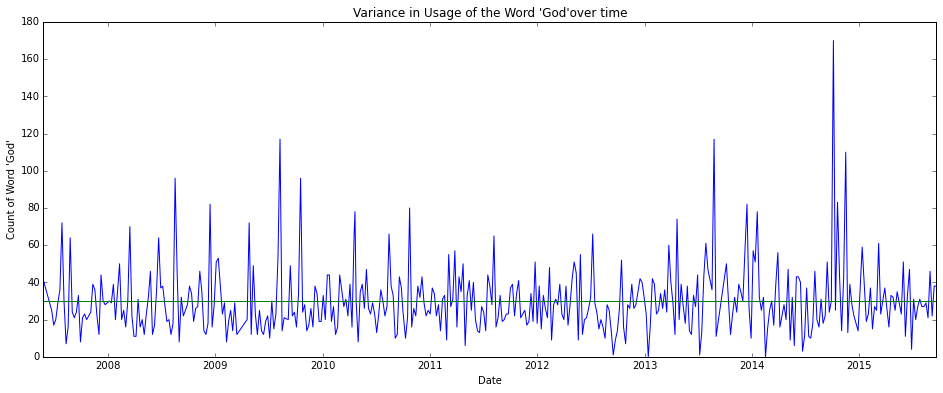

In [113]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.god)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'God'over time")
plt.axhline(fileData.god.mean(), color = 'green')
# plt.xlim(['2007-07-01','2008-07-01'])
plt.show()

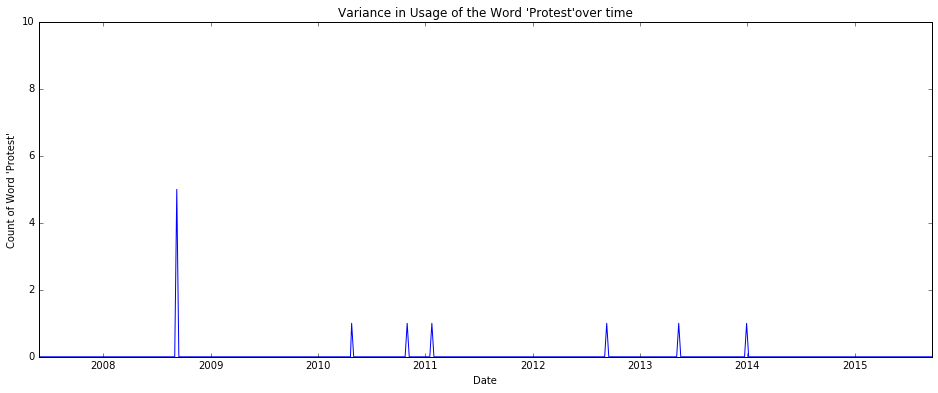

In [159]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.protest_word)
# plt.plot(fileData.date_clean, fileData.wordcount)
plt.ylabel("Count of Word 'Protest'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'Protest'over time")
plt.ylim([0,10])
# plt.axhline(fileData.god.mean(), color = 'green')
plt.show()

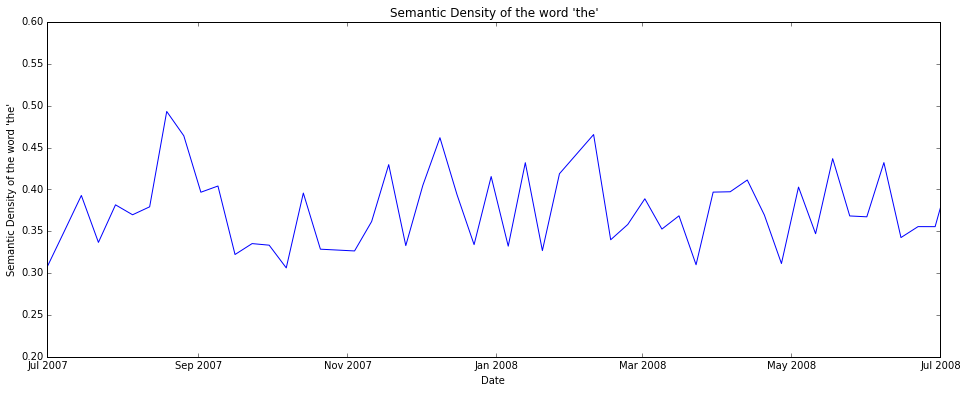

In [225]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.semanticDensity)
# plt.plot(fileData.date_clean, fileData.semanticDensity, 'ro') # Plot Points instead of Line
plt.ylabel("Semantic Density of the word 'the'")
plt.xlabel("Date")
plt.title("Semantic Density of the word 'the'")
plt.ylim([0.2,0.6])
plt.xlim(['2007-07-01','2008-07-01'])
# plt.axhline(fileData.god.mean(), color = 'green')
plt.show()

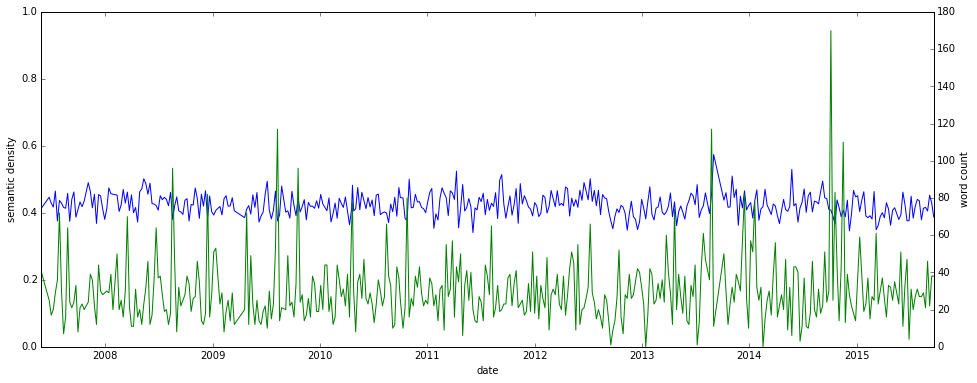

In [114]:
# Plotting w/ 2 Y-Scales
fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(111)
ax1.plot(fileData.date_clean, fileData.semanticDensity)
ax1.set_xlabel('date')
ax1.set_ylabel('semantic density')
ax1.set_ylim([0,1])

ax2 = ax1.twinx()
ax2.plot(fileData.date_clean, fileData.god, 'green')
ax2.set_ylabel('word count')

plt.show()

### Modeling

In [61]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

In [62]:
X = fileData.loc[:,['wordcount','god','protest_word']]
y = fileData.protest

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [64]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [65]:
print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))
confmat=confusion_matrix(y_true=y_test, y_pred=y_pred, labels = [1,0])
print(confmat)

Accuracy: 0.87
[[  0  16]
 [  0 110]]


## Variable Significance Exploration

In [48]:
import statsmodels.api as sm
import pylab as pl

In [49]:
fileData.god.describe()

count    419.000000
mean      27.532220
std       16.849199
min        0.000000
25%       17.000000
50%       24.000000
75%       34.000000
max      151.000000
Name: god, dtype: float64

In [50]:
fileData.std()

protest            0.318869
wordcount       1353.265936
protest_word       0.271057
god               16.849199
dtype: float64

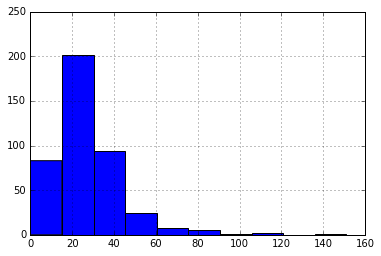

In [51]:
# plot all of the columns, Pretty Slow
fileData.god.hist()
pl.show()

In [72]:
predictor_cols = ['wordcount','god','protest_word']
# Instantiate a gamma family model with the default link function.
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()

In [73]:
len(y_train)

293

In [74]:
print results.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                protest   No. Observations:                  293
Model:                            GLM   Df Residuals:                      290
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -108.80
Date:                Sun, 10 Jul 2016   Deviance:                       217.60
Time:                        09:28:36   Pearson chi2:                     617.
No. Iterations:                    23                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
wordcount       -0.0008      0.000     -5.666      0.000        -0.001    -0.000
god              0.0281      0.015      1.856 

In [76]:
y_preds = results.predict(X_test)

In [79]:
# Convert probabilities to Binary Response for Accuracy
y_preds10 = [1 if pred > 0.5 else 0 for pred in y_preds]

In [89]:
print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))
confmat=confusion_matrix(y_true=y_test, y_pred=y_preds10, labels = [1,0])
print(confmat)

Accuracy: 0.87
[[  0  16]
 [  0 110]]


In [94]:
# Find optimal threshold value
for k in np.arange(float(0),float(1.05),0.05):
    print 'k value: ' + str(k)
    y_preds10 = [1 if pred > k else 0 for pred in y_preds]
    print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))

k value: 0.0
Accuracy: 0.87
k value: 0.05
Accuracy: 0.87
k value: 0.1
Accuracy: 0.87
k value: 0.15
Accuracy: 0.87
k value: 0.2
Accuracy: 0.87
k value: 0.25
Accuracy: 0.87
k value: 0.3
Accuracy: 0.87
k value: 0.35
Accuracy: 0.87
k value: 0.4
Accuracy: 0.87
k value: 0.45
Accuracy: 0.87
k value: 0.5
Accuracy: 0.87
k value: 0.55
Accuracy: 0.87
k value: 0.6
Accuracy: 0.87
k value: 0.65
Accuracy: 0.87
k value: 0.7
Accuracy: 0.87
k value: 0.75
Accuracy: 0.87
k value: 0.8
Accuracy: 0.87
k value: 0.85
Accuracy: 0.87
k value: 0.9
Accuracy: 0.87
k value: 0.95
Accuracy: 0.87
k value: 1.0
Accuracy: 0.87


## Undersampling Due to Class Imbalance

## Adaboost

## Find a Way to Tokenize Scripture

In [171]:
rawText=open(dataloc+files[0]).read()

In [172]:
rawText

'Sunday, May 27, 2007 page 1  Sermon Outline  "Away with such a fellow from the earth; for it is not fit that he should live." Acts 22:22. According to Friday C-J paper, some are talking about a petition demanding Phelps be ousted from Kansas. A sort of persona non grata, like they did in Canada \xad and everywhere else if they get the chance. Beloved, we\'re in good company; this is more evidence our ministry is of God and our calling and election is sure. 2 Pet. 1:10. The mob said of Paul: "Away with such a fellow from the earth; for it is not fit that he should live." Acts 22:22. Of Him Christ said: "But his citizens hated him, and sent a message after him, saying, We will not have this man (Christ) to reign over us." Luke 19:14. "But his citizens hated him, and sent a message after him, saying, We will not have this man (Christ) to reign over us." Luke 19:14. America is a nation of sodomite pagan idolaters, worshiping a flag and worshiping the dead \xad the dunghill gods of ancient

In [129]:
import scriptures

In [131]:
# Returns a 5-tuple ('Book name', start chapter, start verse, end chapter, end verse)
scriptures.extract(rawText)

[(u'Acts', 22, 22, 22, 22),
 (u'Acts', 22, 22, 22, 22),
 (u'Luke', 19, 14, 19, 14),
 (u'Luke', 19, 14, 19, 14),
 (u'Job', 19, 26, 19, 26)]

In [132]:
import re, string

In [36]:
test = 'Job 19:26, 27'
m = re.findall('[a-zA-Z.]+ \d+:\d+', rawText)
print(len(set(m)))
# list(set(m))
m

17


['Acts 22:22',
 'Pet. 1:10',
 'Acts 22:22',
 'Luke 19:14',
 'Luke 19:14',
 'Luke. 18:7',
 'John. 3:16',
 'Jn. 3:16',
 'Rev. 6:10',
 'Psa. 2:1',
 'Heb. 13:8',
 'Rev. 1:13',
 'Rev. 19:14',
 'Jn. 3:2',
 'Job 19:26',
 'Prov. 1:24',
 'Psa. 58:10',
 'Psa. 58:10',
 'Jn. 16:2',
 'Jn. 16:2',
 'Jn. 16:2',
 'Psa. 94:20']

In [43]:
test = 'Job 19:26, 27'
m = re.findall('\d*[ ]*[a-zA-Z.]+ \d+:\d+[,\-][ ]*\d+', rawText)
print(len(set(m)))
list(set(m))

8


[' Prov. 1:24-27',
 'Rev. 1:13-17',
 ' Luke. 18:7, 8',
 ' Psa. 2:1-5',
 ' Rev. 19:14-16',
 ' Psa. 58:10, 11',
 ' Job 19:26, 27',
 ' Jn. 3:16-21']

In [85]:
# Winner, Need to Strip White Space and then Concate somehow or replace to mark as Token/Entiety
test = 'Job 19:26, 27'
m = re.findall('\d*[ ]*[a-zA-Z.]+ \d+:\d+[,\-]*[ ]*\d*', rawText)
print(len(m))
m = [verse.strip() for verse in m]
m = [verse.replace(" ","_") for verse in m]
#m = ['[_'+verse+'_]' for verse in m]
m

22


['Acts_22:22',
 '2_Pet._1:10',
 'Acts_22:22',
 'Luke_19:14',
 'Luke_19:14',
 'Luke._18:7,_8',
 'John._3:16',
 'Jn._3:16-21',
 'Rev._6:10',
 'Psa._2:1-5',
 'Heb._13:8',
 'Rev._1:13-17',
 'Rev._19:14-16',
 '1_Jn._3:2',
 'Job_19:26,_27',
 'Prov._1:24-27',
 'Psa._58:10,_11',
 'Psa._58:10,_11',
 'Jn._16:2',
 'Jn._16:2',
 'Jn._16:2',
 'Psa._94:20']

In [84]:
for verse in list(set(m)):
    rawText = rawText.replace(verse,'[_'+verse.replace(" ","_")+'_]')
rawText

'Sunday, May 27, 2007 page 1  Sermon Outline  "Away with such a fellow from the earth; for it is not fit that he should live." [_Acts 22:22_]. According to Friday C-J paper, some are talking about a petition demanding Phelps be ousted from Kansas. A sort of persona non grata, like they did in Canada \xad and everywhere else if they get the chance. Beloved, we\'re in good company; this is more evidence our ministry is of God and our calling and election is sure. [_2 Pet. 1:10_]. The mob said of Paul: "Away with such a fellow from the earth; for it is not fit that he should live." [_Acts 22:22_]. Of Him Christ said: "But his citizens hated him, and sent a message after him, saying, We will not have this man (Christ) to reign over us." [_Luke 19:14_]. "But his citizens hated him, and sent a message after him, saying, We will not have this man (Christ) to reign over us." [_Luke 19:14_]. America is a nation of sodomite pagan idolaters, worshiping a flag and worshiping the dead \xad the dung

In [186]:
rawText=open(dataloc+files[0]).read()

In [187]:
# Function to pre-process scripture references (before Tokenization) to maintain the references as an enitiety
# @Text - Raw text of a document
# @Returns: Text as Sting
def collect_scripture(rawText):
    # Find all Scripture References
    m = re.findall('\d*[ ]*[a-zA-Z.]+ \d+:\d+[,\-]*[ ]*\d*', rawText)
    # Remove Leading and Tailing Whitespace
    m = [verse.strip() for verse in m]
    # For each unique reference, replace with single string
    for verse in list(set(m)):
        newverse = '_'+verse.replace(" ","_")+'_'
        print ('replaced '+verse+' with '+newverse)
        rawText = rawText.replace(verse,newverse)
    return rawText

In [188]:
rawText = collect_scripture(rawText)

replaced Heb. 13:8 with _Heb._13:8_
replaced Rev. 19:14-16 with _Rev._19:14-16_
replaced Luke 19:14 with _Luke_19:14_
replaced 1 Jn. 3:2 with _1_Jn._3:2_
replaced 2 Pet. 1:10 with _2_Pet._1:10_
replaced Psa. 94:20 with _Psa._94:20_
replaced John. 3:16 with _John._3:16_
replaced Rev. 6:10 with _Rev._6:10_
replaced Jn. 16:2, with _Jn._16:2,_
replaced Rev. 1:13-17 with _Rev._1:13-17_
replaced Luke. 18:7, 8 with _Luke._18:7,_8_
replaced Psa. 2:1-5 with _Psa._2:1-5_
replaced Jn. 16:2 with _Jn._16:2_
replaced Acts 22:22 with _Acts_22:22_
replaced Jn. 3:16-21 with _Jn._3:16-21_
replaced Job 19:26, 27 with _Job_19:26,_27_
replaced Psa. 58:10, 11 with _Psa._58:10,_11_
replaced Prov. 1:24-27 with _Prov._1:24-27_


In [189]:
tokenList=tokenizer.tokenize(rawText)

In [190]:
tokenList

['Sunday',
 ',',
 'May',
 '27',
 ',',
 '2007',
 'page',
 '1',
 'Sermon',
 'Outline',
 '``',
 'Away',
 'with',
 'such',
 'a',
 'fellow',
 'from',
 'the',
 'earth',
 ';',
 'for',
 'it',
 'is',
 'not',
 'fit',
 'that',
 'he',
 'should',
 'live.',
 "''",
 '_Acts_22:22_.',
 'According',
 'to',
 'Friday',
 'C-J',
 'paper',
 ',',
 'some',
 'are',
 'talking',
 'about',
 'a',
 'petition',
 'demanding',
 'Phelps',
 'be',
 'ousted',
 'from',
 'Kansas.',
 'A',
 'sort',
 'of',
 'persona',
 'non',
 'grata',
 ',',
 'like',
 'they',
 'did',
 'in',
 'Canada',
 '\xad',
 'and',
 'everywhere',
 'else',
 'if',
 'they',
 'get',
 'the',
 'chance.',
 'Beloved',
 ',',
 'we',
 "'re",
 'in',
 'good',
 'company',
 ';',
 'this',
 'is',
 'more',
 'evidence',
 'our',
 'ministry',
 'is',
 'of',
 'God',
 'and',
 'our',
 'calling',
 'and',
 'election',
 'is',
 'sure.',
 '_2_Pet._1:10_.',
 'The',
 'mob',
 'said',
 'of',
 'Paul',
 ':',
 '``',
 'Away',
 'with',
 'such',
 'a',
 'fellow',
 'from',
 'the',
 'earth',
 ';',
 '

Going to need to modify the pre-processing steps to not strip the scripture references. Also need to get rid of empty tokens. Plus tokens that are just puncuation.

In [193]:
tokenList = clean_text(tokenList)
tokenList

['sunday',
 'may',
 'num',
 'num',
 'page',
 'num',
 'sermon',
 'outline',
 'away',
 'with',
 'such',
 'a',
 'fellow',
 'from',
 'the',
 'earth',
 'for',
 'it',
 'is',
 'not',
 'fit',
 'that',
 'he',
 'should',
 'live',
 '_acts_22:22',
 'according',
 'to',
 'friday',
 'c-j',
 'paper',
 'some',
 'are',
 'talking',
 'about',
 'a',
 'petition',
 'demanding',
 'phelps',
 'be',
 'ousted',
 'from',
 'kansas',
 'a',
 'sort',
 'of',
 'persona',
 'non',
 'grata',
 'like',
 'they',
 'did',
 'in',
 'canada',
 '\xad',
 'and',
 'everywhere',
 'else',
 'if',
 'they',
 'get',
 'the',
 'chance',
 'beloved',
 'we',
 "'re",
 'in',
 'good',
 'company',
 'this',
 'is',
 'more',
 'evidence',
 'our',
 'ministry',
 'is',
 'of',
 'god',
 'and',
 'our',
 'calling',
 'and',
 'election',
 'is',
 'sure',
 '_2_pet._1:10',
 'the',
 'mob',
 'said',
 'of',
 'paul',
 'away',
 'with',
 'such',
 'a',
 'fellow',
 'from',
 'the',
 'earth',
 'for',
 'it',
 'is',
 'not',
 'fit',
 'that',
 'he',
 'should',
 'live',
 '_acts_2

In [199]:
l = ['a','b','c']
l = [letter for letter in l if letter != 'c']
l

['a', 'b']

In [191]:
import re
p = re.compile('\d*[ ]*[a-zA-Z.]+ \d+:\d+[,\-]*[ ]*\d*')
for m in p.finditer(rawText):
    #print m.span(), m.group()
    print m.group()
    verse = str(m.group())
    rawText = rawText.replace(str(m.group),'[_'+str(m.group)+'_]')
print rawText

Sunday, May 27, 2007 page 1  Sermon Outline  "Away with such a fellow from the earth; for it is not fit that he should live." _Acts_22:22_. According to Friday C-J paper, some are talking about a petition demanding Phelps be ousted from Kansas. A sort of persona non grata, like they did in Canada � and everywhere else if they get the chance. Beloved, we're in good company; this is more evidence our ministry is of God and our calling and election is sure. _2_Pet._1:10_. The mob said of Paul: "Away with such a fellow from the earth; for it is not fit that he should live." _Acts_22:22_. Of Him Christ said: "But his citizens hated him, and sent a message after him, saying, We will not have this man (Christ) to reign over us." _Luke_19:14_. "But his citizens hated him, and sent a message after him, saying, We will not have this man (Christ) to reign over us." _Luke_19:14_. America is a nation of sodomite pagan idolaters, worshiping a flag and worshiping the dead � the dunghill gods of ancie

In [42]:
test = 'Job 19:26, 27'
m = re.findall('\d*[ ]*[a-zA-Z.]+ \d+:\d+', rawText)
print(len(set(m)))
list(set(m))

17


[' Psa. 2:1',
 ' Prov. 1:24',
 ' Heb. 13:8',
 ' Jn. 16:2',
 ' Luke 19:14',
 '2 Pet. 1:10',
 ' John. 3:16',
 ' Luke. 18:7',
 ' Rev. 19:14',
 'Rev. 1:13',
 ' Rev. 6:10',
 ' Psa. 58:10',
 ' Acts 22:22',
 ' Job 19:26',
 ' Psa. 94:20',
 ' Jn. 3:16',
 '1 Jn. 3:2']

In [55]:
test = 'Job 19:26, 27'
m = re.findall('[a-zA-Z.]+ \d+:\d+', rawText)
print(len(m))
m

['Acts 22:22',
 'Pet. 1:10',
 'Acts 22:22',
 'Luke 19:14',
 'Luke 19:14',
 'Luke. 18:7',
 'John. 3:16',
 'Jn. 3:16',
 'Rev. 6:10',
 'Psa. 2:1',
 'Heb. 13:8',
 'Rev. 1:13',
 'Rev. 19:14',
 'Jn. 3:2',
 'Job 19:26',
 'Prov. 1:24',
 'Psa. 58:10',
 'Psa. 58:10',
 'Jn. 16:2',
 'Jn. 16:2',
 'Jn. 16:2',
 'Psa. 94:20']

In [56]:
test = 'Job 19:26, 27'
m = re.findall('\d [a-zA-Z.]+ \d+:\d+', rawText)
m

['2 Pet. 1:10', '1 Jn. 3:2']

In [145]:
m.string[m.start(test):m.end(test)]

IndexError: no such group

### Metadata for Dorothy Day

In [9]:
dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/data_dsicap/DorothyDay/raw/'

In [10]:
files = os.listdir(dataloc)

files = [file for file in files if '.txt' in file]

fileData = pd.DataFrame(files, columns = ['fileName'])

In [11]:
fileData[0:5]

,fileName
0,12.html.txt
1,13.html.txt
2,142.html.txt
3,143.html.txt
4,145.html.txt


In [12]:
samp = files[0]

In [13]:
text = rawText=open(dataloc+"/"+samp, encoding = 'latin1').read()

In [14]:
import string

In [15]:
firstlines = []
for file in fileData.fileName:
    text = rawText=open(dataloc+"/"+file, encoding = 'latin1').read()
    lineone = text[0:text[1:len(text)].find('\n')+1]
    lineone = re.sub('\nThe Catholic Worker, ','',lineone)
    firstlines.append(lineone)

In [16]:
fileData['firstline'] = firstlines

In [17]:
list(fileData.firstline)

['May 1933, 4 (First Issue)',
 'April 1934, 3-4.',
 'January 1936, 4.',
 'January 1936, 1-2.',
 'February 1938, 1-2.',
 'September 1938, 1,3,4.',
 'April 1941, 1,4.',
 'February 1943, 1,4.',
 'February 1944, 1,8.',
 'February 1935, 7.',
 'February 1945, 1-2.',
 'February 1945, 3,7.',
 'September 1945, 6.',
 'November 1945, 1.',
 'September 1946, 1,3,7,8.',
 'May 1947, 1,3.',
 'December 1947, 1.',
 'May 1948.',
 'June 1948, 1, 2, 7.',
 'December 1935, 4.',
 'July-August 1948, 1,2, 6.',
 'December 1948, 1,3.',
 'February 1949, 1-2.',
 'July-August 1949, 1-2.',
 'October 1949, 4,6.',
 'November 1949, 1,2,4.',
 'May 1950, 1-2.',
 'January 1953, 1,7.',
 'May 1953, 1-2.',
 'June 1953, 2,6.',
 'July-August 1953, 1,7.',
 'September 1953, 2,6.',
 'March 1954, 2,4.',
 'October 1954, 1,6.',
 'May 1955, 2.',
 'May 1958, 1,3,11.',
 'January 1959, 1,2,7.',
 'July-August 1969.',
 'December 1974, 1-2.',
 'February 1940, 7.',
 'Jan 1948, 2,8.',
 'April 1952, 1, 7',
 'January 1941, 1,7.',
 'December 193

In [25]:
# Building Parsing for Dates in DD Files
date_est = []
for i in range(0,len(fileData)):
    if fileData.loc[i,'firstline'][0] == '\n':
        # print(fileData.loc[i,'firstline'][0])
        print("Drop")
        date_est.append('unclear date')
    else:
        # print(fileData.loc[i,'firstline'][0])
        # print("Keep")
        pieces = fileData.loc[i,'firstline'].split(" ")
        if len(pieces[1]) != 5:
            date_est.append('unclear date')
        else:
            date_est.append(pieces[0]+', '+pieces[1][0:4])
            print(pieces)

['May', '1933,', '4', '(First', 'Issue)']
['April', '1934,', '3-4.']
['January', '1936,', '4.']
['January', '1936,', '1-2.']
['February', '1938,', '1-2.']
['September', '1938,', '1,3,4.']
['April', '1941,', '1,4.']
['February', '1943,', '1,4.']
['February', '1944,', '1,8.']
['February', '1935,', '7.']
['February', '1945,', '1-2.']
['February', '1945,', '3,7.']
['September', '1945,', '6.']
['November', '1945,', '1.']
['September', '1946,', '1,3,7,8.']
['May', '1947,', '1,3.']
['December', '1947,', '1.']
['May', '1948.']
['June', '1948,', '1,', '2,', '7.']
['December', '1935,', '4.']
['July-August', '1948,', '1,2,', '6.']
['December', '1948,', '1,3.']
['February', '1949,', '1-2.']
['July-August', '1949,', '1-2.']
['October', '1949,', '4,6.']
['November', '1949,', '1,2,4.']
['May', '1950,', '1-2.']
['January', '1953,', '1,7.']
['May', '1953,', '1-2.']
['June', '1953,', '2,6.']
['July-August', '1953,', '1,7.']
['September', '1953,', '2,6.']
['March', '1954,', '2,4.']
['October', '1954,', '

In [26]:
len(date_est)

774

In [27]:
len(fileData)

774

In [28]:
fileData['date_est'] = date_est

In [34]:
import datetime

In [47]:
datelist = []
for date in date_est:
    try:
        datelist.append(datetime.datetime.strptime(date, '%B, %Y'))
    except ValueError:
        datelist.append(date)

In [48]:
datelist[0:4]

[datetime.datetime(1933, 5, 1, 0, 0),
 datetime.datetime(1934, 4, 1, 0, 0),
 datetime.datetime(1936, 1, 1, 0, 0),
 datetime.datetime(1936, 1, 1, 0, 0)]

In [50]:
from collections import Counter

In [57]:
pd.DataFrame(fileData['date_est'])['date_est'].value_counts()

unclear date         71
January, 1936         4
November, 1954        4
May, 1940             4
October, 1948         4
March, 1954           4
Oct, 1933             4
April, 1955           4
May, 1967             4
June, 1955            4
June, 1942            3
September, 1954       3
May, 1950             3
Nov, 1933             3
November, 1956        3
November, 1953        3
December, 1936        3
May, 1953             3
March, 1938           3
October, 1954         3
October, 1969         3
May, 1956             3
January, 1947         3
April, 1966           3
November, 1946        3
July-August, 1947     3
April, 1953           3
April, 1954           3
December, 1937        3
November, 1957        3
                     ..
July-August, 1933     1
December, 1966        1
March, 1957           1
October, 1976         1
June, 1978            1
May, 1964             1
February, 1939        1
December, 1944        1
Mar, 1954             1
January, 1959         1
Feb, 1934       

### Document-Level Sentiment

In [168]:
#Import packages
import sys
import numpy as np
#sys.path.append('./prototype_python/')
#import syntacticParsing as sp
#import semanticDensity as sd

#Get sentimentWord dict and remove duplicates. Store in lists
posFilePath='/refData/positive-words.txt'
negFilePath='/refData/negative-words.txt'
posWords=list(set(tokenize('..',posFilePath)))
negWords=list(set(tokenize('..',negFilePath)))

#Define packages

def sentimentLookup(tokens):
    fileSentiment=[]
    #Get sentiment for each document
    # for filename in tokens.keys():
        
    #initialize counters
    wordCount=0.0
    posCount=0.0
    negCount=0.0

    #Get counts
    for token in tokens:
        #Add to word count
        wordCount=wordCount+1        

        #Check if positive
        if token in posWords:
            posCount=posCount+1

        #Check if negative
        if token in negWords:
            negCount=negCount+1

    #Calculate percentages and append to list
    posPer=posCount/wordCount
    negPer=negCount/wordCount
    fileSentiment.append([posPer,negPer])
    
    #Calculate average sub-group level word sentiment percent
    #wordSentiment=np.mean(np.array(fileSentiment),axis=0)
    
    #Calculate sub-group level doc sentiment percent
    #posDocCount=float(len([x for x in fileSentiment if x[0]>x[1]]))
    #posDocPer=posDocCount/len(fileSentiment)
    #negDocPer=1-posDocPer
    #output=[wordSentiment[0],wordSentiment[1],posDocPer,negDocPer]   
    
    return(fileSentiment)

In [172]:
start=datetime.datetime.now()
sentiment=[]
for file in fileData.fileName:
    print(file)
    sent = sentimentLookup(tokenLists[file])
    sentiment.append(sent) # Returns %pos, %neg, #pos, #
print(datetime.datetime.now()-start)

WestboroBaptist_Sermon_20070527.pdf.txt
WestboroBaptist_Sermon_20070624.pdf.txt
WestboroBaptist_Sermon_20070701.pdf.txt
WestboroBaptist_Sermon_20070708.pdf.txt
WestboroBaptist_Sermon_20070715.pdf.txt
WestboroBaptist_Sermon_20070722.pdf.txt
WestboroBaptist_Sermon_20070729.pdf.txt
WestboroBaptist_Sermon_20070805.pdf.txt
WestboroBaptist_Sermon_20070812.pdf.txt
WestboroBaptist_Sermon_20070819.pdf.txt
WestboroBaptist_Sermon_20070826.pdf.txt
WestboroBaptist_Sermon_20070902.pdf.txt
WestboroBaptist_Sermon_20070909.pdf.txt
WestboroBaptist_Sermon_20070916.pdf.txt
WestboroBaptist_Sermon_20070923.pdf.txt
WestboroBaptist_Sermon_20070930.pdf.txt
WestboroBaptist_Sermon_20071007.pdf.txt
WestboroBaptist_Sermon_20071014.pdf.txt
WestboroBaptist_Sermon_20071021.pdf.txt
WestboroBaptist_Sermon_20071104.pdf.txt
WestboroBaptist_Sermon_20071111.pdf.txt
WestboroBaptist_Sermon_20071118.pdf.txt
WestboroBaptist_Sermon_20071125.pdf.txt
WestboroBaptist_Sermon_20071202.pdf.txt
WestboroBaptist_Sermon_20071209.pdf.txt


### Document-Level Network Analysis

In [21]:
#import syntacticParsing as sp
import networkQuantification as nq

In [52]:
# Make DSM from Document
# Still need to get Target Words
network=[]
for file in fileData.fileName:
    print(file)
    #Get word coCo for Single Document
    CoCo, TF, docTF = sd.coOccurence({file: tokenLists[file]},k=2)
    #Get DSM for Single Document
    DSM=sd.DSM(CoCo,100)
    # txtstr = getRawText(dataloc,fileData.fileName[0])
    targetwords = sp.targetWords(getRawText(dataloc,file),wordCount=10,startCount=0)
    result=nq.getNetworkQuant(DSM,targetwords,30)
    network.append(result)
fileData['network']=network

WestboroBaptist_Sermon_20070527.pdf.txt
WestboroBaptist_Sermon_20070624.pdf.txt
WestboroBaptist_Sermon_20070701.pdf.txt
WestboroBaptist_Sermon_20070708.pdf.txt
WestboroBaptist_Sermon_20070715.pdf.txt
WestboroBaptist_Sermon_20070722.pdf.txt
WestboroBaptist_Sermon_20070729.pdf.txt
WestboroBaptist_Sermon_20070805.pdf.txt
WestboroBaptist_Sermon_20070812.pdf.txt
WestboroBaptist_Sermon_20070819.pdf.txt
WestboroBaptist_Sermon_20070826.pdf.txt
WestboroBaptist_Sermon_20070902.pdf.txt
WestboroBaptist_Sermon_20070909.pdf.txt
WestboroBaptist_Sermon_20070916.pdf.txt
WestboroBaptist_Sermon_20070923.pdf.txt
WestboroBaptist_Sermon_20070930.pdf.txt
WestboroBaptist_Sermon_20071007.pdf.txt
WestboroBaptist_Sermon_20071014.pdf.txt
WestboroBaptist_Sermon_20071021.pdf.txt
WestboroBaptist_Sermon_20071104.pdf.txt
WestboroBaptist_Sermon_20071111.pdf.txt
WestboroBaptist_Sermon_20071118.pdf.txt
WestboroBaptist_Sermon_20071125.pdf.txt
WestboroBaptist_Sermon_20071202.pdf.txt
WestboroBaptist_Sermon_20071209.pdf.txt


In [54]:
fileData[0:4]

,fileName,date,network,date_clean
0,WestboroBaptist_Sermon_20070527.pdf.txt,20070527,0.307361,2007-05-27
1,WestboroBaptist_Sermon_20070624.pdf.txt,20070624,0.369185,2007-06-24
2,WestboroBaptist_Sermon_20070701.pdf.txt,20070701,0.364819,2007-07-01
3,WestboroBaptist_Sermon_20070708.pdf.txt,20070708,0.580916,2007-07-08


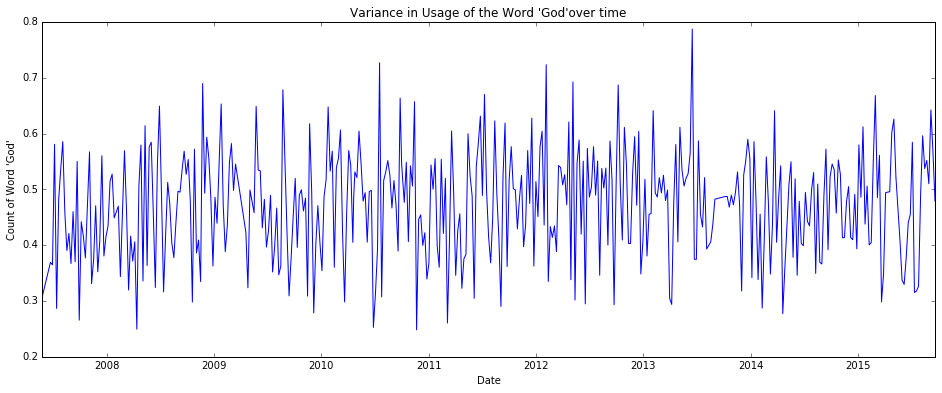

In [55]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.network)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'God'over time")
#plt.axhline(fileData.god.mean(), color = 'green')
# plt.xlim(['2007-07-01','2008-07-01'])
plt.show()

### Document-Level Judgements

In [38]:
import syntacticParsing as sp

In [50]:
wordList=sp.targetWords(txtstr,wordCount=10,startCount=0)

In [51]:
wordList

['not',
 'when',
 'only',
 'more',
 'now',
 'dead',
 'even',
 'righteous',
 'verily',
 'old']

In [ ]:
judgementList=[sp.judgements(sp.readText(fileName)) for fileName in subFileList]
judgementAvg=list(np.mean(np.array(judgementList),axis=0))    
txtString=' '.join([sp.readText(fileName) for fileName in subFileList])


In [49]:
txtstr = getRawText(dataloc,fileData.fileName[0])

In [48]:
def getRawText(path2File, file):
    tokens={}
    # print(path2File+file)
    #Clean raw text into token list
    rawText=open(path2File+file).read()
    rawText=str(unicode(rawText, "utf-8", errors="ignore"))
    return rawText

In [82]:
judgements=[]
for file in fileData.fileName:
    print(file)
    rawText = getRawText(dataloc,file)
    targetwords = sp.targetWords(rawText,wordCount=10,startCount=0)
    percent=sp.judgements(rawText)
    judgements.append(percent)
    #judgementAvg=list(np.mean(np.array(judgementList),axis=0))

WestboroBaptist_Sermon_20070527.pdf.txt
WestboroBaptist_Sermon_20070624.pdf.txt
WestboroBaptist_Sermon_20070701.pdf.txt
WestboroBaptist_Sermon_20070708.pdf.txt
WestboroBaptist_Sermon_20070715.pdf.txt
WestboroBaptist_Sermon_20070722.pdf.txt
WestboroBaptist_Sermon_20070729.pdf.txt
WestboroBaptist_Sermon_20070805.pdf.txt
WestboroBaptist_Sermon_20070812.pdf.txt
WestboroBaptist_Sermon_20070819.pdf.txt
WestboroBaptist_Sermon_20070826.pdf.txt
WestboroBaptist_Sermon_20070902.pdf.txt
WestboroBaptist_Sermon_20070909.pdf.txt
WestboroBaptist_Sermon_20070916.pdf.txt
WestboroBaptist_Sermon_20070923.pdf.txt
WestboroBaptist_Sermon_20070930.pdf.txt
WestboroBaptist_Sermon_20071007.pdf.txt
WestboroBaptist_Sermon_20071014.pdf.txt
WestboroBaptist_Sermon_20071021.pdf.txt
WestboroBaptist_Sermon_20071104.pdf.txt
WestboroBaptist_Sermon_20071111.pdf.txt
WestboroBaptist_Sermon_20071118.pdf.txt
WestboroBaptist_Sermon_20071125.pdf.txt
WestboroBaptist_Sermon_20071202.pdf.txt
WestboroBaptist_Sermon_20071209.pdf.txt


In [83]:
j=[judge[1] for judge in judgements]
fileData['judgements']=j

In [84]:
judgements[3]

[16, 0.13559322033898305]

In [60]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [61]:
txtString="I am really tired for no reason. Second sentence"

In [62]:
tokenizer.tokenize(txtString)

['I am really tired for no reason.', 'Second sentence']

In [80]:
fileData[0:2]

,fileName,date,network,date_clean,judgements
0,WestboroBaptist_Sermon_20070527.pdf.txt,20070527,0.307361,2007-05-27,0.139535
1,WestboroBaptist_Sermon_20070624.pdf.txt,20070624,0.369185,2007-06-24,0.139535


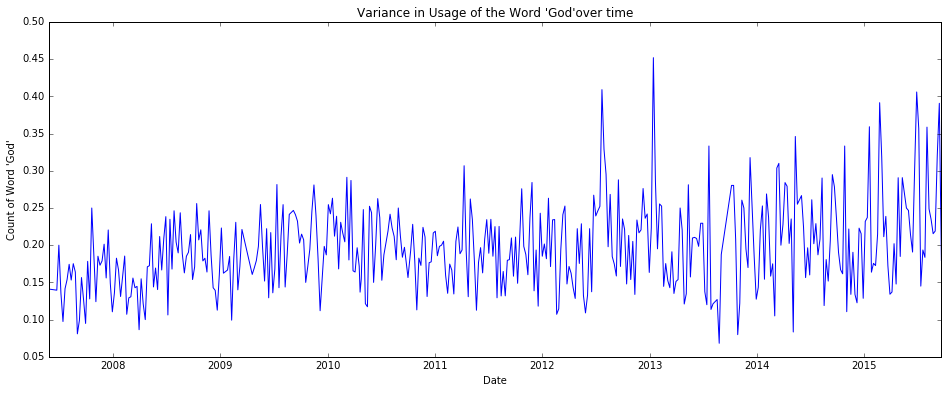

In [85]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.judgements)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'God'over time")
#plt.axhline(fileData.god.mean(), color = 'green')
# plt.xlim(['2007-07-01','2008-07-01'])
plt.show()